# NFL Circle of Parity

An NFL Circle of Parity (or as some prefer to say Circle of Suck) is a graph that "suggests" any team could theoretically beat any other team in the league. 

![DraftKings Circle of Parity](nfl-circle-of-parity-draftkings.jpg)

Here's an example of one from the 2024 NFL season I got from the DraftKings Sportsbook facebook. Here is how you read it. Starting with the Chargers, they beat the Saints week 8. The Cardinals beat the Chargers week 7. This relationship continues until we settle on the Saints who beat the Cowboys week 5, completing the circle. By the transitive property, each team "lost" to every other team (this is why some call it a Circle of Suck). 

Its not hard to convince yourself there is no reason one of these circles should exist. Sometimes they are impossible (for example, when one team has never lost a game or never won a game). It turns out finding these circles in general is "hard" as they belong to a class of problems called NP-complete. In graph theory a Circle of Parity is called a Hamiltonian Circuit.

# Finding a Hamiltonian Circuit from Scratch

Its nice of DraftKings to provide us with an example of a Circle of Parity but what if we wanted to find our own? What if this isn't the only path that exists? How do we go about solving this problem?

## Finding the Data

We will use the nfl_data_py library to import the regular season NFL match results.

In [84]:
import nfl_data_py as nfl
import pandas as pd

We'll manually calculate who wins each match and create our own data frame.

In [85]:
# Get the game data for the 2024 season
games = nfl.import_schedules([2024])

# Filter out postseason games
games = games[games['week'] <= 17]

# Isolate relevant columns
games = games[['week', 'home_team', 'away_team', 'home_score', 'away_score']]

# Create a new column for the winner and loser
games['winner'] = games.apply(lambda row: row['home_team'] if row['home_score'] > row['away_score'] else row['away_team'], axis=1)
games['loser'] = games.apply(lambda row: row['away_team'] if row['home_score'] > row['away_score'] else row['home_team'], axis=1)

# Select only the columns we want (week, winner, and loser)
games = games[['week', 'winner', 'loser']]

print(games.head())


      week winner loser
6706     1     KC   BAL
6707     1    PHI    GB
6708     1    PIT   ATL
6709     1    BUF   ARI
6710     1    CHI   TEN


## Building the Graph

In [86]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

def build_graph(games):
    # Create a directed graph
    G = nx.DiGraph()
    
    # Add edges from winner to loser
    for index, row in games.iterrows():
        G.add_edge(row['winner'], row['loser'])

    return G

## Visualizing the Graph

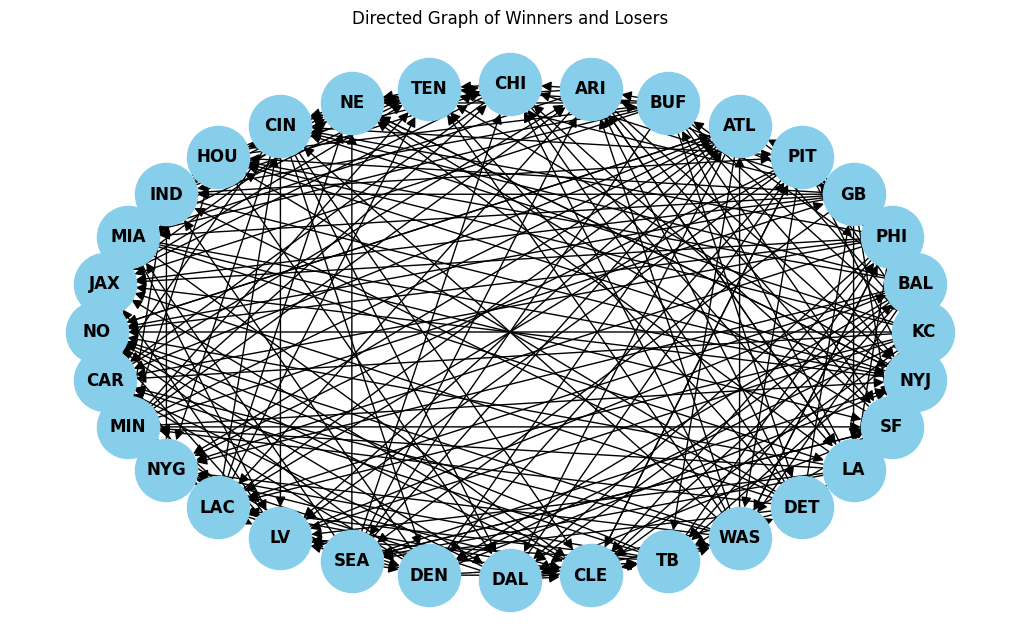

In [87]:
G = build_graph(games)

pos = nx.circular_layout(G)
plt.figure(figsize=(10, 6))
nx.draw(G, pos, with_labels=True, node_size=2000, node_color='skyblue', font_size=12, font_weight='bold', arrowsize=15)
plt.title('Directed Graph of Winners and Losers')
plt.show()

## Solving with Backtracking

Hamiltonian Circuit: ['KC', 'BAL', 'DAL', 'CLE', 'JAX', 'IND', 'CHI', 'TEN', 'MIA', 'NE', 'CIN', 'CAR', 'LV', 'NO', 'ATL', 'PHI', 'PIT', 'WAS', 'NYG', 'SEA', 'SF', 'TB', 'DET', 'LA', 'MIN', 'GB', 'ARI', 'LAC', 'DEN', 'NYJ', 'HOU', 'BUF', 'KC']


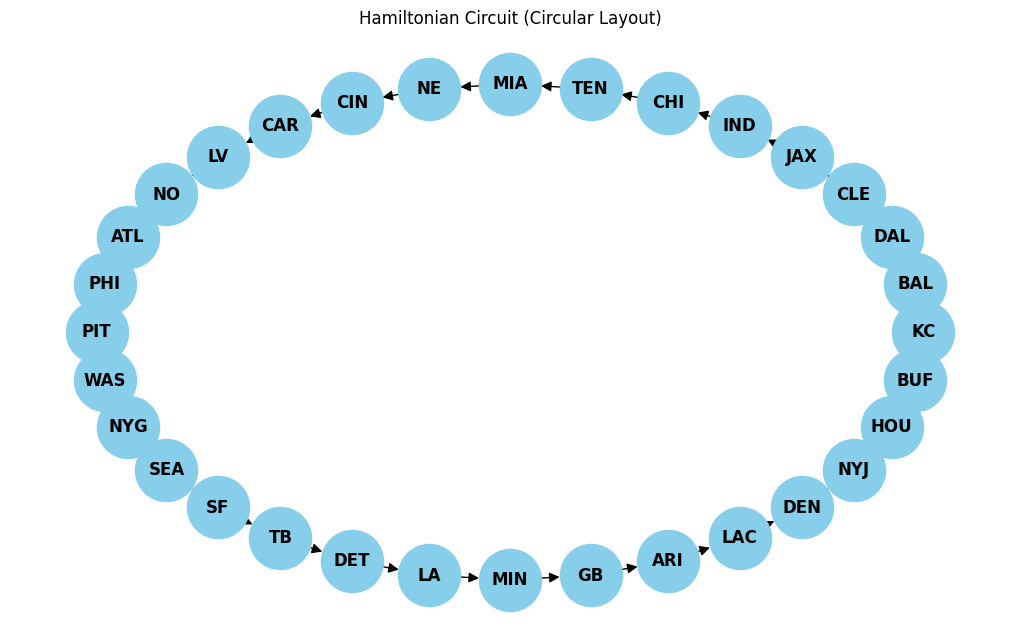

In [88]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt

def find_hamiltonian_circuit(graph):
    nodes = list(graph.nodes)
    path = [nodes[0]] 
    
    def backtrack(current_node, visited):
        if len(path) == len(nodes) and path[0] in graph.successors(current_node):
            path.append(path[0])
            return True
        for neighbor in graph.successors(current_node):
            if neighbor not in visited:
                visited.add(neighbor)
                path.append(neighbor)
                if backtrack(neighbor, visited):
                    return True
                path.pop() 
                visited.remove(neighbor)
        return False

    visited_set = {nodes[0]}
    if backtrack(nodes[0], visited_set):
        return path
    else:
        return None

# Find the Hamiltonian circuit
hamiltonian_circuit = find_hamiltonian_circuit(build_graph(games))

if hamiltonian_circuit:
    print(f"Hamiltonian Circuit: {hamiltonian_circuit}")
    
    # Create an empty graph for the circuit
    H = nx.DiGraph()
    for i in range(len(hamiltonian_circuit) - 1):
        H.add_edge(hamiltonian_circuit[i], hamiltonian_circuit[i + 1])

    # Filter the DataFrame to only include rows corresponding to the Hamiltonian circuit
    filtered_rows = []
    for i in range(len(hamiltonian_circuit) - 1):
        winner = hamiltonian_circuit[i]
        loser = hamiltonian_circuit[i + 1]
        filtered_row = df[(df['winner'] == winner) & (df['loser'] == loser)]
        filtered_rows.append(filtered_row)

    # Concatenate the filtered rows into a single DataFrame
    df_filtered = pd.concat(filtered_rows)

    # Create a new graph from the filtered DataFrame
    H = nx.DiGraph()
    for index, row in df_filtered.iterrows():
        H.add_edge(row['winner'], row['loser'])

    # Use a circular layout for the graph
    pos = nx.circular_layout(H)
    
    plt.figure(figsize=(10, 6))
    nx.draw(H, pos, with_labels=True, node_size=2000, node_color='skyblue', 
            font_size=12, font_weight='bold', arrowsize=15)
    plt.title('Hamiltonian Circuit (Circular Layout)')
    plt.show()

else:
    print("No Hamiltonian Circuit found.")


      week winner loser
6706     1     KC   BAL
6749     3    BAL   DAL
6718     1    DAL   CLE
6728     2    CLE   JAX
6775     5    JAX   IND
6740     3    IND   CHI
6710     1    CHI   TEN
6768     4    TEN   MIA
6776     5    MIA    NE
6877    12    MIA    NE
6711     1     NE   CIN
6756     4    CIN   CAR
6746     3    CAR    LV
6954    17     LV    NO
6850    10     NO   ATL
6737     2    ATL   PHI
6926    15    PHI   PIT
6852    10    PIT   WAS
6732     2    WAS   NYG
6836     9    WAS   NYG
6781     5    NYG   SEA
6868    11    SEA    SF
6851    10     SF    TB
6726     2     TB   DET
6720     1    DET    LA
6813     8     LA   MIN
6983    19     LA   MIN
6758     4    MIN    GB
6959    17    MIN    GB
6787     6     GB   ARI
6812     7    ARI   LAC
6792     6    LAC   DEN
6930    16    LAC   DEN
6761     4    DEN   NYJ
6829     9    NYJ   HOU
6774     5    HOU   BUF
6869    11    BUF    KC


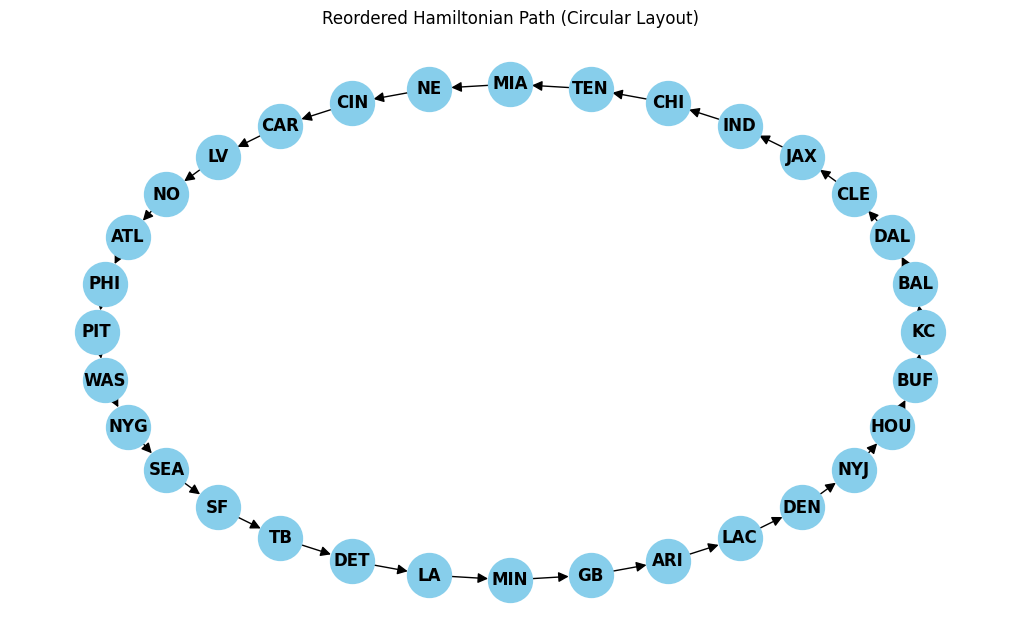

In [89]:
# Create an empty graph for the Hamiltonian path
if hamiltonian_circuit:
    H = nx.DiGraph()
    for i in range(len(hamiltonian_circuit) - 1):
        H.add_edge(hamiltonian_circuit[i], hamiltonian_circuit[i + 1])

    filtered_rows = []
    for i in range(len(hamiltonian_circuit) - 1):
        winner = hamiltonian_circuit[i]
        loser = hamiltonian_circuit[i + 1]
        
        filtered_row = df[(df['winner'] == winner) & (df['loser'] == loser)]
        filtered_rows.append(filtered_row)

    df_filtered = pd.concat(filtered_rows)


    # Create a new directed graph based on the reordered DataFrame
    H_reordered = nx.DiGraph()
    for index, row in df_filtered.iterrows():
        H_reordered.add_edge(row['winner'], row['loser'])
    
    # Reorder nodes based on the Hamiltonian path order
    hamiltonian_circuit_set = set(hamiltonian_circuit)  # Hamiltonian path nodes
    ordered_nodes = [node for node in hamiltonian_circuit if node in hamiltonian_circuit_set]
    
    # Use a circular layout with the manually ordered nodes
    pos = nx.circular_layout(H_reordered)  # Pass the reordered node list
    
    plt.figure(figsize=(10, 6))
    
    # Draw the graph with the correct node order
    nx.draw(H_reordered, pos, with_labels=True, node_size=1000, node_color='skyblue', font_size=12, font_weight='bold', arrowsize=15)
    
    plt.title('Reordered Hamiltonian Path (Circular Layout)')
    plt.show()

else:
    print("No Hamiltonian Path found.")

Our circuit is different from DraftKings. This suggests there can be more than one unique circuit for a given directed graph.